# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype = str)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype = str)

In [8]:
#calculate median for each column
azdias_median = azdias.median()
customer_median = customers.median()

In [11]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [12]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [62]:
#Identify the columns which contain nan more than 50% 
customers.isna().mean().loc[customers.isna().mean() > 0.5]

ALTER_KIND1     0.938607
ALTER_KIND2     0.973389
ALTER_KIND3     0.993347
ALTER_KIND4     0.998769
KK_KUNDENTYP    0.584064
dtype: float64

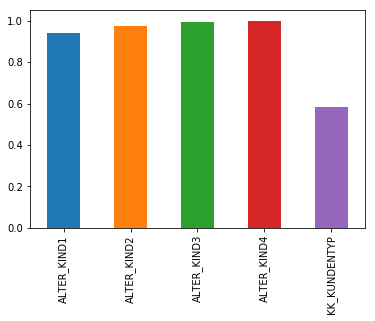

In [9]:
customers.isna().mean().loc[customers.isna().mean() > 0.5].plot.bar(rot=90)

In [63]:
#Identify the columns which contain nan more than 50% 
azdias.isna().mean().loc[azdias.isna().mean() > 0.5]

ALTER_KIND1     0.909048
ALTER_KIND2     0.966900
ALTER_KIND3     0.993077
ALTER_KIND4     0.998648
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
similarity      0.873549
dtype: float64

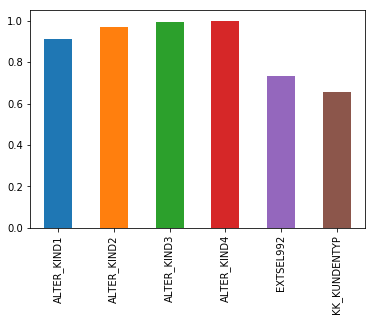

In [6]:
azdias.isna().mean().loc[azdias.isna().mean() > 0.5].plot.bar(rot=90)

In [5]:
#drop the unique columns in the customer df
customer_median = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1).median()

In [10]:
azdias_median.loc[abs(azdias_median - customer_median) > 2.0]

LNR                      637263.0
ALTERSKATEGORIE_FEIN         14.0
ANZ_HAUSHALTE_AKTIV           4.0
D19_KONSUMTYP_MAX             8.0
D19_SONSTIGE                  0.0
EINGEZOGENAM_HH_JAHR       2003.0
GEBURTSJAHR                1943.0
GFK_URLAUBERTYP               8.0
HH_EINKOMMEN_SCORE            5.0
KBA13_ANZAHL_PKW            549.0
LP_LEBENSPHASE_FEIN          11.0
LP_STATUS_FEIN                4.0
PRAEGENDE_JUGENDJAHRE         8.0
VK_DISTANZ                    8.0
VK_ZG11                       6.0
dtype: float64

In [11]:
#explore customer data, see the data from the customer segments ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')
Customer_Groups = customers["CUSTOMER_GROUP"].unique()
Customer_Groups

array(['MULTI_BUYER', 'SINGLE_BUYER'], dtype=object)

In [9]:
#explore customer data, see the data from the customer segments ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')
Online_purchases = customers["ONLINE_PURCHASE"].unique()
Online_purchases

array(['0', '1'], dtype=object)

In [10]:
#explore customer data, see the data from the customer segments ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP')
Product_groups = customers["PRODUCT_GROUP"].unique()
Product_groups

array(['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'], dtype=object)

In [6]:
#caluculate median for each group of "CUSTOMER_GROUP"
median_multi_buyer = customers[customers["CUSTOMER_GROUP"] == 'MULTI_BUYER'].median()
median_single_buyer = customers[customers["CUSTOMER_GROUP"] == 'SINGLE_BUYER'].median()

In [32]:
#To see the difference between the distribution of multi buyer and that of single using median
median_multi_buyer.loc[abs(median_multi_buyer - median_single_buyer) > 1.0]

LNR                 95878.5
AGER_TYP                1.0
EXTSEL992              36.0
GEBURTSJAHR          1923.0
KBA13_ANZAHL_PKW      596.0
SEMIO_KAEM              3.0
dtype: float64

In [18]:
#To see the difference between the distribution of "online purchase = 0" and that of "online purchase = 1" using median
#caluculate median for each group of "CUSTOMER_GROUP"
median_OnlinePurchase_1 = customers[customers["ONLINE_PURCHASE"] == "1"].median()
median_OnlinePurchase_0 = customers[customers["ONLINE_PURCHASE"] == "0"].median()
median_OnlinePurchase_1.loc[abs(median_OnlinePurchase_1 - median_OnlinePurchase_0) > 1.0]

LNR                            97215.0
AGER_TYP                          -1.0
ALTER_HH                          16.0
ALTERSKATEGORIE_FEIN              14.0
D19_GESAMT_DATUM                   5.0
D19_GESAMT_ONLINE_DATUM            6.0
D19_GESAMT_ONLINE_QUOTE_12         9.0
D19_VERSAND_DATUM                  6.0
D19_VERSAND_ONLINE_DATUM           7.0
D19_VERSAND_ONLINE_QUOTE_12        8.0
EINGEZOGENAM_HH_JAHR            2001.0
EXTSEL992                         35.0
FINANZ_ANLEGER                     3.0
GEBURTSJAHR                     1948.0
KBA13_ANZAHL_PKW                 597.0
LP_LEBENSPHASE_FEIN               19.0
ONLINE_AFFINITAET                  4.0
PRAEGENDE_JUGENDJAHRE              6.0
W_KEIT_KIND_HH                     3.0
dtype: float64

In [19]:
#To see the difference among the distribution of "COSMETIC", that of "FOOD" and that of "COSMETIC_AND_FOOD" using median
#caluculate median for each group of "CUSTOMER_GROUP"
median_food = customers[customers["PRODUCT_GROUP"] == "FOOD"].median()
median_cosmetic = customers[customers["PRODUCT_GROUP"] == "COSMETIC"].median()
median_cosmeticandfood = customers[customers["PRODUCT_GROUP"] == "COSMETIC_AND_FOOD"].median()

In [29]:
#food vs cosmetic
median_food.loc[abs(median_food - median_cosmetic) > 1.0]

LNR            95398.0
EXTSEL992         36.0
GEBURTSJAHR     1934.0
dtype: float64

In [30]:
#food vs cosmeticandfood
median_food.loc[abs(median_food - median_cosmeticandfood) > 1.0]

LNR                 95398.0
AGER_TYP               -1.0
GEBURTSJAHR          1934.0
KBA13_ANZAHL_PKW      589.0
SEMIO_KAEM              5.0
dtype: float64

In [31]:
#cosmetic vs cosmeticandfood
median_cosmetic.loc[abs(median_cosmetic - median_cosmeticandfood) > 1.0]

LNR                 95978.0
EXTSEL992              39.0
GEBURTSJAHR          1926.0
KBA13_ANZAHL_PKW      588.0
SEMIO_KAEM              5.0
dtype: float64

In [35]:
#calculate median for each column
azdias_median = azdias.median()
#drop the unique columns in the customer df
customer_median = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1).median()

In [36]:
#the num of columns that we can not find median
abs(len(customers.columns) - len(customer_median))

9

In [37]:
#columns that we can not find median
set(customers.columns) - set(customer_median.index)

{'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CUSTOMER_GROUP',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'ONLINE_PURCHASE',
 'OST_WEST_KZ',
 'PRODUCT_GROUP'}

In [12]:
#need to change data
customers["CAMEO_DEUG_2015"].unique() #to remove X (CAMEO classification 2015 - Uppergroup)
customers["CAMEO_DEU_2015"].unique() #to remove XX (we can remove this?)
#customers["CAMEO_INTL_2015"].unique() #to remove XX (No description in the csv file, we can remove this?)
#customers["D19_LETZTER_KAUF_BRANCHE"].unique() #to drop (No description in the csv file, we can remove this?)
#customers["EINGEFUEGT_AM"].unique() #to drop (No description in the csv file, we can remove this?)
#customers["OST_WEST_KZ"].unique() #flag for East or West (We can change W to 1, O to 0)

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [35]:
"""
Data preprocessing TODO
1. drop columns which have more than 80% nan values
2. Drop columns which are not going to be used
3. Transform values in the columns which are requred to be changed
"""
def preprocessing_data_part1():
    list_todrop = ["CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE", "EINGEFUEGT_AM", "ALTER_KIND1", "ALTER_KIND2", "ALTER_KIND3", "ALTER_KIND4"]
    df_customers = customers.drop(list_todrop, axis=1)
    df_azdias = azdias.drop(list_todrop, axis=1)
    
    df_customers["CAMEO_DEUG_2015"] = df_customers["CAMEO_DEUG_2015"].replace("X", np.nan)
    df_azdias["CAMEO_DEUG_2015"] = df_azdias["CAMEO_DEUG_2015"].replace("X", np.nan)
    
    df_customers["CAMEO_DEU_2015"] = pd.get_dummies(df_customers["CAMEO_DEU_2015"])
    df_azdias["CAMEO_DEU_2015"] = pd.get_dummies(df_azdias["CAMEO_DEU_2015"])
    #df_customers["CAMEO_DEU_2015"] = df_customers["CAMEO_DEU_2015"].replace("XX", np.nan)
    #df_azdias["CAMEO_DEU_2015"] = df_azdias["CAMEO_DEU_2015"].replace("XX", np.nan)
    
    df_customers["OST_WEST_KZ"] = df_customers["OST_WEST_KZ"].replace("W", "1").replace("O", "0")
    df_azdias["OST_WEST_KZ"] = df_azdias["OST_WEST_KZ"].replace("W", "1").replace("O", "0")
    
    df_customers = df_customers.dropna()#.reset_index()
    df_azdias = df_azdias.dropna()#.reset_index()
    
    return df_customers, df_azdias

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
#To understand the difference between the distribution of azdias and that of customer using median
#if the median for the certain column is different from one another, the distribution should be also different,
#meaning that the certain columns is an unique key to tell the difference between two.

In [147]:
azdias_median.loc[abs(azdias_median - customer_median) > 1.0]

LNR                            631730.0
AGER_TYP                           -1.0
ALTERSKATEGORIE_FEIN               14.0
D19_REISEN                          0.0
D19_VERSAND_ONLINE_QUOTE_12        10.0
D19_VERSICHERUNGEN                  2.0
EINGEZOGENAM_HH_JAHR             1998.0
EXTSEL992                          36.0
GEBURTSJAHR                      1957.0
KBA13_ANZAHL_PKW                  576.0
LP_FAMILIE_FEIN                     8.0
LP_LEBENSPHASE_FEIN                28.0
LP_LEBENSPHASE_GROB                 8.0
PRAEGENDE_JUGENDJAHRE               8.0
ZABEOTYP                            3.0
dtype: float64

In [36]:
#preprocessing the data only for part1
df_customers, df_azdias = preprocessing_data_part1()

In [37]:
df_azdias = df_azdias.drop(["similarity"], axis=1)

In [38]:
#calculate median
#calculate median for each column
azdias_median = df_azdias.median()
customer_median = df_customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1).median()

In [29]:
set(df_azdias.columns) - set(customer_median.index)

{'similarity'}

In [39]:
"""
One way to predict what kind of people are goinng to be the company's customer is 
calculate similarity between each person in azdias and median or mean of the customers.
We then can say which person is going to be the comapny's customer.
"""

#calculate similarity 
sims = []
for i in df_azdias.index:
    sim = np.linalg.norm(np.array(customer_median.apply(lambda x: float(x))) - np.array(df_azdias.loc[i].apply(lambda x: float(x))))
    sims.append(sim)
df_azdias["similarity"] = sims

In [44]:
#show similarities
df_azdias["similarity"] /= df_azdias["similarity"].max()
1 - df_azdias["similarity"].sort_values()

694525    0.903062
778113    0.903054
700022    0.903040
778110    0.903039
700026    0.903020
694529    0.903019
700028    0.903005
778121    0.902988
703238    0.902981
700032    0.902979
710867    0.902979
761111    0.902953
774491    0.902944
768512    0.902933
734408    0.902928
710173    0.902916
778890    0.902915
734416    0.902891
761117    0.902882
786933    0.902867
791318    0.902863
768519    0.902862
707583    0.902851
727774    0.902845
764186    0.902838
713948    0.902835
451085    0.902826
397683    0.902804
429316    0.902799
422555    0.902793
            ...   
409816    0.000236
400518    0.000211
409823    0.000200
400519    0.000192
475054    0.000182
415032    0.000163
415034    0.000160
635824    0.000146
635826    0.000144
685690    0.000139
692087    0.000129
611157    0.000128
644814    0.000114
625386    0.000100
630086    0.000098
644817    0.000078
644819    0.000065
672853    0.000063
641026    0.000049
625399    0.000044
644821    0.000043
649365    0.

In [ ]:
#compare

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [17]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
def build_model():
    """
    Build Model function
    
    This function output is a Scikit ML Pipeline that process text messages
    according to NLP best-practice and apply a classifier.
    """
    pipeline = Pipeline([
        ('clf', RandomForestClassifier())
    ])
    
    parameters = {
    'clf__n_estimators': [50, 60, 100, 200],
    'clf__min_samples_split': [2, 3, 4],
    }

    return GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc')

In [19]:
def build_model2():
    """
    Build Model function
    
    This function output is a Scikit ML Pipeline that process text messages
    according to NLP best-practice and apply a classifier.
    """
    pipeline = Pipeline([
        ('clf', GradientBoostingClassifier())
    ])
    
    parameters = {
        'clf__learning_rate': [0.1, 0.2],
        'clf__n_estimators': [100],
        'clf__max_depth': [3, 5],
        'clf__min_samples_split': [2, 4]
    }

    return GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc')

In [20]:
def evaluate_model(model, X_test, Y_test):
    """
    Evaluate Model function
    
    This function applies ML pipeline to a test set and prints out
    model performance (accuracy and f1score)
    
    Arguments:
        model -> Scikit ML Pipeline
        X_test -> test features
        Y_test -> test labels
    """
    Y_pred = model.predict(X_test)
    #classification_report(Y_test, Y_pred)
    
    # calculate fpr, tpr, thresholds
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)

    #calculate auc
    auc = metrics.auc(fpr, tpr)

    #plot roc
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

In [21]:
"""
Data preprocessing TODO
1. drop columns which have more than 80% nan values
2. Drop columns which are not going to be used
3. Transform values in the columns which are requred to be changed
"""
def preprocessing_data_part2(df):
    list_todrop = ["LNR", "KK_KUNDENTYP", "EXTSEL992","CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE", "EINGEFUEGT_AM", "ALTER_KIND1", "ALTER_KIND2", "ALTER_KIND3", "ALTER_KIND4"]
    df = df.drop(list_todrop, axis=1)
    
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].replace("X", np.nan)
    
    df["CAMEO_DEU_2015"] = pd.get_dummies(df["CAMEO_DEU_2015"])
    
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace("W", "1").replace("O", "0")
    
    df = df.fillna(df.median())
    
    return df

In [22]:
"""
Feature selection based on spearmanr
input: df, num of important columns
output: list of important columns
"""
def sp_feature_selection(X_train, Y_train, n=10):
    corrs = {}
    for column in X_train.columns:
        corr = np.corrcoef(np.array(X_train[column].apply(lambda x: float(x))), 
                           np.array(Y_train.apply(lambda x: float(x))))[0,1]
        corrs[column] = corr
    corrs_sorted = sorted(corrs.items(), key=lambda x:x[1], reverse=True)
    return [corrs_sorted[i][0] for i in range(n)]

In [23]:
#preprocessing data
df = preprocessing_data_part2(mailout_train)
Y_train = df["RESPONSE"]
X_train = df.drop(["RESPONSE"], axis=1)

In [24]:
#feature selection
list_important_features = sp_feature_selection(X_train, Y_train, n=300)
X_train = X_train[list_important_features]

In [25]:
print('Building model...')
model = build_model2()

print('Training model...')
model.fit(X_train, Y_train)

Building model...
Training model...


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
 ...     presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__learning_rate': [0.1, 0.2], 'clf__n_estimators': [100], 'clf__max_depth': [3, 5], 'clf__min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [26]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
#check the lenth
len(mailout_test)

42833

In [28]:
#preprocessing data
df_test = preprocessing_data_part2(mailout_test)

In [29]:
#check the length after processing
len(df_test)

42833

In [30]:
#we can use this method if we have Y_test but it is not available this time
#evaluate_model(model, X_test, Y_test)

In [31]:
Y_proba_test = model.predict_proba(df_test[list_important_features])
df_proba = pd.DataFrame(Y_proba_test)

df_test["RESPONSE"] = df_proba[1]
df_test["LNR"] = mailout_test["LNR"]
df_test[["LNR", "RESPONSE"]]

,LNR,RESPONSE
0,1754,0.029827
1,1770,0.010785
2,1465,0.024634
3,1470,0.004304
4,1478,0.008312
5,1782,0.004996
6,1485,0.007754
7,1519,0.011523
8,1835,0.003058
9,1522,0.015374


In [32]:
df_test[df_test["RESPONSE"] > 0.5]["RESPONSE"]

2852     0.706719
2960     0.815222
3271     0.996824
5240     0.824596
8162     0.981096
9661     0.725131
9710     0.999199
10050    0.535107
10673    0.971548
10758    0.819789
12742    0.657254
16288    0.700758
16366    0.999579
18506    0.987108
19322    0.685748
22223    0.978938
22746    0.998894
26031    0.580361
26896    0.937102
27197    0.945194
27323    0.935505
30172    0.817787
31835    0.790275
33387    0.681330
34959    0.979387
35441    0.846537
38558    0.997467
39271    0.654122
Name: RESPONSE, dtype: float64

In [33]:
df_test[["LNR", "RESPONSE"]].to_csv("submission.csv", index=False)

In [36]:
df_test[df_test["RESPONSE"] > 0.5].mean()

AGER_TYP                         -0.142857
AKT_DAT_KL                        1.892857
ALTER_HH                         14.392857
ALTERSKATEGORIE_FEIN             13.321429
ANZ_HAUSHALTE_AKTIV               7.892857
ANZ_HH_TITEL                      0.214286
ANZ_KINDER                        0.607143
ANZ_PERSONEN                      2.500000
ANZ_STATISTISCHE_HAUSHALTE        6.964286
ANZ_TITEL                         0.214286
ARBEIT                            2.571429
BALLRAUM                          4.642857
CAMEO_DEU_2015                    0.071429
CJT_GESAMTTYP                     3.750000
CJT_KATALOGNUTZER                 2.857143
CJT_TYP_1                         3.250000
CJT_TYP_2                         3.000000
CJT_TYP_3                         3.392857
CJT_TYP_4                         3.250000
CJT_TYP_5                         3.428571
CJT_TYP_6                         3.428571
D19_BANKEN_ANZ_12                 0.142857
D19_BANKEN_ANZ_24                 0.392857
D19_BANKEN_

In [35]:
!tar chvfz notebook.tar.gz *

Arvato Project Workbook.ipynb
Arvato-Project-Workbook-zh.ipynb
DIAS Attributes - Values 2017.xlsx
DIAS Information Levels - Attributes 2017.xlsx
notebook.tar.gz
tar: notebook.tar.gz: file changed as we read it
submission.csv
terms_and_conditions/
terms_and_conditions/terms.pdf
terms_and_conditions/terms.md
terms_and_conditions/.ipynb_checkpoints/
terms_and_conditions/terms_completed.md
